# Extract a latent dimension (direction) in the semantic space learned by Word2Vec using an ALTERNATE geometric approach

"Dimension," "direction" and "subspace" are used in this notebook interchangeably to refer to a vector that captures a bipolar concept such as "gender" which ranges continously from hypermasculine to hyperfeminine, or "socioeconomic status" which ranges from poor to rich. 

We can **see how "biased" a word is learned by Word2Vec by** projecting it onto an extracted dimension. We'll get a scalar that corresponds to the learned bias. 
* To use gender bias as an example - a larger, positive projection of a word onto the gender dimension suggests this word is learned as highly feminine, while a larger, negative proejction of a word onto the gender dimension suggests that this word is learned as highly masculine. A word with a projection near zero suggests that Word2Vec learned this word as gender-neutral. 

* Dimensions in this juypter notebook that are ready for extraction are **gender, morality, health,** and **ses**. Code is easily modifiable to extract other dimensions that may be interesting, you will need to adjust the training/testing words and corresponding labels. 
* This code is written for use with Word2Vec models, easily modifiable for other word-vector models as well. 

Methods are inspired by Bolukbasi et. al. 2016 (https://arxiv.org/abs/1607.06520) which quantifies gender biases in Word2Vec models. 

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold 
from gensim.models import Word2Vec
from sklearn import preprocessing
np.set_printoptions(threshold=np.inf) #do this if you want to print full output
from sklearn.decomposition import PCA #don't necessarily need
import csv
import gensim
import statistics
from random import randint
from collections import Counter
import matplotlib.pyplot as plt
from scipy import spatial
%matplotlib inline

C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Upload a Trained Word2Vec Model In Which You Want to Find a Dimensions

*Don't have a model? Use a pretrained Word2Vec Model from Google, trained on Google News*
* Read and download here: https://code.google.com/archive/p/word2vec/
* File is called "GoogleNews-vectors-negative300.bin.gz"

*What you will need to change in this code includes:*
* currentmodel = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  
* Some of the vocabulary words used to extract subspace may not exist, and you will get errors and need to find substitutes for these words. 

In [2]:
currentmodel=  Word2Vec.load("Word2VecModels/modelA_ALLYEARS_500dim_10CW")

# Find a Gender/Moral/Health/SES Dimension
* Choose a set of word pairs that best represent extremes of the diemsnions you are trying to capture. Such as man/woman to capture a gender dimension. 
* Words may be used more than once if there is no better antonym. Enter the words from each pair below, in order. 
* If you're not sure if your word choices are any good, try cross validation across the word possiblities to see how sensitive the process is to word choice. 

In [3]:
def select_training_set(trainingset): #options are: gender, moral, health, ses
    #gender is the training set used for the PCA approach
    #gender_2 has fewer precise gender words like "he" vs "she" than set 1,  and some more noise via words that are gendered but less clearcut than Set1)
    #gender_3 even fewer precise gender words like "he" vs "she" than set 1,  and same added noise as training set 2

    if trainingset=='gender_2':
        pos_word_list=[ 'girl', 'girls', 'her', 'hers', 'herself', 'she', 
            'lady', 'gal', 'gals', 'madame', 'ladies', 'lady',
          'mother', 'mothers', 'mom', 'moms', 'mommy', 'mama', 'ma', 'granddaughter', 'daughter', 'daughters', 'aunt', 'godmother', 
          'grandma', 'grandmothers', 'grandmother', 'sister', 'sisters', 'aunts', 'stepmother', 'granddaughters', 'niece',
        'fiancee', 'ex_girlfriend', 'girlfriends', 'wife', 'wives', 'girlfriend', 'bride', 'brides', 'widow',
           'twin_sister', 'younger_sister', 'teenage_girl', 'teenage_girls', 'eldest_daughter','estranged_wife', 'schoolgirl',
        'businesswoman', 'congresswoman' , 'chairwoman', 'councilwoman', 'waitress', 'hostess', 'convent', 'heiress', 
           'saleswoman', 'queen', 'queens', 'princess', 'nun' , 'nuns', 'heroine', 'actress', 'actresses', 'uterus', 'vagina', 'ovarian_cancer',
        'maternal', 'maternity', 'motherhood', 'sisterhood', 'girlhood', 'matriarch', 'sorority', 'mare', 'hen', 'hens', 'filly', 'fillies',
          'deer', 'older_sister', 'oldest_daughter', 'stepdaughter', 'pink',  'cute', 'dependent', 'nurturing', 'hysterical', 'bitch',  'dance', 'dancing'] 
        neg_word_list=['boy', 'boys', 'him', 'his', 'himself', 'he', 'guy', 'dude',
            'dudes', 'sir', 'guys', 'gentleman','father', 'fathers', 'dad', 'dads', 'daddy', 'papa', 'pa', 'grandson' , 'son', 'sons', 'uncle', 'godfather', 
        'grandpa', 'grandfathers', 'grandfather', 'brother', 'brothers' , 'uncles', 'stepfather', 'grandsons', 'nephew',
           'fiance', 'ex_boyfriend', 'boyfriends', 'husband', 'husbands', 'boyfriend', 'groom', 'grooms', 'widower',
            'twin_brother', 'younger_brother', 'teenage_boy', 'teenage_boys', 'eldest_son', 'estranged_husband', 'schoolboy',
            'businessman', 'congressman', 'chairman', 'councilman', 'waiter', 'host', 'monastery', 'heir', 'salesman', 
            'king', 'kings', 'prince', 'monk', 'monks', 'hero', 'actor', 'actors', 'prostate', 'penis', 'prostate_cancer', 
        'paternal', 'paternity', 'fatherhood', 'brotherhood', 'boyhood', 'patriarch', 'fraternity', 'stallion', 'rooster', 'roosters', 'colt',
           'colts', 'bull', 'older_brother', 'oldest_son', 'stepson', 'blue' ,'manly', 'independent', 'aggressive', 'angry', 'jerk', 'wrestle', 'wrestling'  ]
        pos_word_replacement='woman'
        neg_word_replacement='man'
    elif trainingset=='gender_3':
        pos_word_list=['madame', 'ladies', 'lady',
          'mother', 'mothers', 'mom', 'mama', 'granddaughter', 'daughter', 'daughters', 'aunt', 'godmother', 
          'grandma', 'grandmothers', 'grandmother', 'sister', 'sisters', 'aunts', 'stepmother', 'granddaughters', 'niece',
        'fiancee', 'ex_girlfriend', 'girlfriends', 'wife', 'wives', 'girlfriend', 'bride', 'brides', 'widow',
           'twin_sister', 'younger_sister', 'teenage_girl', 'teenage_girls', 'eldest_daughter','estranged_wife', 'schoolgirl',
        'businesswoman', 'congresswoman' , 'chairwoman', 'councilwoman', 'waitress', 'hostess', 'convent', 'heiress', 
           'saleswoman', 'queen', 'queens', 'princess', 'nun' , 'nuns', 'heroine', 'actress', 'actresses', 'uterus', 'vagina', 'ovarian_cancer',
        'maternal', 'maternity', 'motherhood', 'sisterhood', 'girlhood', 'matriarch', 'sorority', 'mare', 'hen', 'hens', 'filly', 'fillies',
          'deer', 'older_sister', 'oldest_daughter', 'stepdaughter', 'pink', 'cute', 'dependent', 'nurturing', 'hysterical', 'bitch',  'dance', 'dancing']
        neg_word_list=['sir', 'guys', 'gentleman','father', 'fathers', 'dad', 'papa', 'grandson' , 'son', 'sons', 'uncle', 'godfather', 
        'grandpa', 'grandfathers', 'grandfather', 'brother', 'brothers' , 'uncles', 'stepfather', 'grandsons', 'nephew',
           'fiance', 'ex_boyfriend', 'boyfriends', 'husband', 'husbands', 'boyfriend', 'groom', 'grooms', 'widower',
            'twin_brother', 'younger_brother', 'teenage_boy', 'teenage_boys', 'eldest_son', 'estranged_husband', 'schoolboy',
            'businessman', 'congressman', 'chairman', 'councilman', 'waiter', 'host', 'monastery', 'heir', 'salesman', 
            'king', 'kings', 'prince', 'monk', 'monks', 'hero', 'actor', 'actors', 'prostate', 'penis', 'prostate_cancer', 
        'paternal', 'paternity', 'fatherhood', 'brotherhood', 'boyhood', 'patriarch', 'fraternity', 'stallion', 'rooster', 'roosters', 'colt',
           'colts', 'bull', 'older_brother', 'oldest_son', 'stepson', 'blue' ,'manly', 'independent', 'aggressive', 'angry', 'jerk', 'wrestle', 'wrestling'  ]
        pos_word_replacement='woman'
        neg_word_replacement='man'
    elif trainingset=='gender':
        pos_word_list=['womanly', 'my_wife', 'my_mom', 'my_grandmother', 'woman', 'women', 'girl', 'girls', 'her', 'hers', 'herself', 'she', 
            'lady', 'gal', 'gals', 'madame', 'ladies', 'lady',
          'mother', 'mothers', 'mom', 'moms', 'mommy', 'mama', 'ma', 'granddaughter', 'daughter', 'daughters', 'aunt', 'godmother', 
          'grandma', 'grandmothers', 'grandmother', 'sister', 'sisters', 'aunts', 'stepmother', 'granddaughters', 'niece',
          'fiancee', 'ex_girlfriend', 'girlfriends', 'wife', 'wives', 'girlfriend', 'bride', 'brides', 'widow',
           'twin_sister', 'younger_sister', 'teenage_girl', 'teenage_girls', 'eldest_daughter','estranged_wife', 'schoolgirl',
          'businesswoman', 'congresswoman' , 'chairwoman', 'councilwoman', 'waitress', 'hostess', 'convent', 'heiress', 
           'saleswoman', 'queen', 'queens', 'princess', 'nun' , 'nuns', 'heroine', 'actress', 'actresses', 'uterus', 'vagina', 'ovarian_cancer',
           'maternal', 'maternity', 'motherhood', 'sisterhood', 'girlhood', 'matriarch', 'sorority', 
         'older_sister', 'oldest_daughter', 'stepdaughter']
        neg_word_list=['manly', 'my_husband', 'my_dad','my_grandfather', 'man', 'men', 'boy', 'boys', 'him', 'his', 'himself', 'he', 'guy', 'dude',
            'dudes', 'sir', 'guys', 'gentleman','father', 'fathers', 'dad', 'dads', 'daddy', 'papa', 'pa', 'grandson' , 'son', 'sons', 'uncle', 'godfather', 
           'grandpa', 'grandfathers', 'grandfather', 'brother', 'brothers' , 'uncles', 'stepfather', 'grandsons', 'nephew',
           'fiance', 'ex_boyfriend', 'boyfriends', 'husband', 'husbands', 'boyfriend', 'groom', 'grooms', 'widower',
            'twin_brother', 'younger_brother', 'teenage_boy', 'teenage_boys', 'eldest_son', 'estranged_husband', 'schoolboy',
            'businessman', 'congressman', 'chairman', 'councilman', 'waiter', 'host', 'monastery', 'heir', 'salesman', 
            'king', 'kings', 'prince', 'monk', 'monks', 'hero', 'actor', 'actors', 'prostate', 'penis', 'prostate_cancer', 
           'paternal', 'paternity', 'fatherhood', 'brotherhood', 'boyhood', 'patriarch', 'fraternity', 
           'older_brother', 'oldest_son', 'stepson']
        pos_word_replacement='woman'
        neg_word_replacement='man'
    elif trainingset=='moral':
        pos_word_list= ['good', 'benevolent', 'nice', 'caring', 'conscientious', 'polite', 'fair', 'virtue', 'respect', 'responsible', 
            'selfless', 'unselfish', 'sincere', 'truthful', 'wonderful', 'justice', 'innocent', 'innocence',
           'complement', 'sympathetic', 'virtue', 'right', 'proud', 'pride','respectful', 'appropriate', 'pleasing', 'pleasant', 
            'pure', 'decent', 'pleasant', 'compassion' , 'compassionate', 'constructive','graceful', 'gentle', 'reliable',
           'careful', 'help', 'decent' , 'moral', 'hero', 'heroic', 'heroism', 'honest', 'honesty',
           'selfless', 'humility', 'humble', 'generous', 'generosity', 'faithful', 'fidelity', 'worthy', 'tolerant',
            'obedient', 'pious', 'saintly', 'angelic', 'virginal', 'sacred', 'reverent', 'god', 'hero', 'heroic', 
            'forgiving', 'saintly','holy', 'chastity', 'grateful', 'considerate', 'humane', 
            'trustworthy', 'loyal', 'loyalty', 'empathetic', 'empathy', 'clean', 'straightforward', 'pure']
        neg_word_list= ['bad', 'evil', 'mean', 'uncaring', 'lazy', 'rude', 'unfair', 'sin', 'disrespect','irresponsible', 
           'self_centered', 'selfish', 'insincere', 'lying', 'horrible', 'injustice', 'guilty', 'guilt', 
            'insult', 'unsympathetic', 'vice', 'wrong', 'ashamed', 'shame', 'disrespectful', 'inappropriate', 'vulgar', 'crude', 
            'dirty', 'obscene', 'offensive', 'cruelty','brutal', 'destructive', 'rude', 'harsh', 'unreliable',
            'careless', 'harm', 'indecent', 'immoral', 'coward', 'cowardly', 'cowardice', 'dishonest', 'dishonesty',
            'narcissistic', 'arrogance', 'arrogant', 'greedy', 'greed', 'betray', 'betrayal', 'unworthy', 'intolerant', 
             'defiant', 'rebellious', 'demonic','devilish', 'promiscuous', 'profane', 'irreverent', 'devil', 'villain', 'villainous', 
            'vindictive', 'diabolical', 'unholy', 'promiscuity', 'ungrateful', 'thoughtless', 'inhumane',
            'untrustworthy', 'treacherous', 'treachery', 'callous', 'indifference', 'dirty', 'manipulative', 'impure' ]
        pos_word_replacement='moral'
        neg_word_replacement='immoral'
    elif trainingset=='health':
        pos_word_list= ['fertile', 'help_prevent', 'considered_safe', 'safer', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
            'healthful', 'well_balanced', 'natural', 'healthy', 'athletic','physically_active', 'health',
            'health', 'nutritious','nourishing', 'stronger', 'strong','wellness', 'safe', 'nutritious_food','exercise',
            'physically_fit', 'unprocessed', 'healthier_foods', 'nutritious_foods', 'nutritious', 'nutritious',
           'healthy_eating', 'healthy_diet', 'healthy_diet', 'nourishing', 'nourished', 'regular_exercise', 'safety', 'safe', 
            'helpful', 'beneficial', 'healthy', 'healthy', 'sturdy', 'lower_risk', 'reduced_risk', 'decreased_risk', 'nutritious_foods', 'whole_grains', 'healthier_foods',
            'healthier_foods', 'physically_active', 'physical_activity', 'nourished', 'vitality', 'energetic', 'able_bodied',
            'resilience', 'strength', 'less_prone', 'sanitary', 'clean',  'healing', 'heal', 'salubrious']   
        neg_word_list= ['infertile', 'cause_harm','potentially_harmful','riskier', 'unhealthy', 'sick', 'ill', 'frail', 'sickly', 
            'unhealthful','unbalanced', 'unnatural', 'dangerous', 'sedentary', 'inactive', 'illness', 
            'sickness', 'toxic', 'unhealthy', 'weaker', 'weak', 'illness', 'unsafe', 'unhealthy_foods', 'sedentary',
            'inactive', 'highly_processed', 'processed_foods', 'junk_foods', 'unhealthy_foods', 'junk_foods',
               'processed_foods', 'processed_foods', 'fast_food', 'unhealthy_foods', 'deficient', 'sedentary', 'hazard','hazardous', 
            'harmful', 'injurious',  'chronically_ill', 'seriously_ill', 'frail', 'higher_risk', 'greater_risk', 'increased_risk', 'fried_foods', 'fried_foods',
            'fatty_foods', 'sugary_foods', 'sedentary', 'physical_inactivity', 'malnourished', 'lethargy', 'lethargic', 'disabled',
            'susceptibility', 'weakness', 'more_susceptible', 'filthy', 'dirty', 'harming', 'hurt', 'deleterious']
        pos_word_replacement='healthy'
        neg_word_replacement='ill'
    elif trainingset=='ses':
        pos_word_list=['wealth', 'wealthier', 'wealthiest', 'affluence', 'prosperity', 'wealthy', 'affluent', 'affluent', 'prosperous',
                'prosperous','prosperous','disposable_income',  'wealthy','suburban','luxurious','upscale','upscale', 'luxury', 
                'richest', 'privileged', 'moneyed', 'privileged', 'privileged', 'educated', 'employed', 
                'elite', 'upper_income', 'upper_class', 'employment', 'riches', 'millionaire', 'aristocrat', 'college_educated',
                'abundant', 'lack', 'luxury', 'profitable', 'profit', 'well_educated', 'elites', 'heir', 'well_heeled', 
                'white_collar', 'higher_incomes', 'bourgeois', 'fortunate', 'successful','economic_growth', 'prosper', 'suburbanites']
        neg_word_list= ['poverty', 'poorer', 'poorest', 'poverty', 'poverty', 'impoverished', 'impoverished',  'needy',  'impoverished',
                 'poor', 'needy', 'broke', 'needy', 'slum', 'ghetto', 'slums', 'ghettos', 'poor_neighborhoods', 
                'poorest', 'underserved', 'disadvantaged','marginalized', 'underprivileged', 'uneducated', 'unemployed', 
                'marginalized', 'low_income', 'underclass','unemployment', 'rags', 'homeless', 'peasant', 'college_dropout', 
                'lacking', 'abundance', 'squalor', 'bankrupt', 'debt', 'illiterate' ,'underclass', 'orphan',  'destitute', 
                'blue_collar', 'low_income', 'neediest', 'less_fortunate', 'unsuccessful', 'economic_crisis', 'low_wage', 'homeless']
        pos_word_replacement='wealthy'
        neg_word_replacement='poor'
    pos_words=[]
    neg_words=[]
    pos_word_list_checked=[]
    neg_word_list_checked=[]
    for i in pos_word_list:
        try:
            pos_words.append(currentmodel[i])
            pos_word_list_checked.append(i)
        except KeyError:
            print(str(i) +  ' was not in this Word2Vec models vocab, and has been replaced with: ' + str(pos_word_replacement) )
            pos_words.append(currentmodel[pos_word_replacement])
            pos_word_list_checked.append(pos_word_replacement)
    for i in neg_word_list:
        try:
            neg_words.append(currentmodel[i])
            neg_word_list_checked.append(i)
        except KeyError:
            print(str(i) +  ' was not in this Word2Vec models vocab, and has been replaced with: ' + str(neg_word_replacement) )
            neg_words.append(currentmodel[neg_word_replacement])
            neg_word_list_checked.append(neg_word_replacement)

    print("Number of pos words: " + str(len(pos_words)) + " Number of neg words: " + str(len(neg_words)))
    train_classes_pos=np.array(np.repeat(1, len(pos_words)).tolist()) #1 is feminine/moral/healthy/rich by default, we will need to find the correct labels inductively
    train_classes_neg=np.array(np.repeat(0, len(neg_words)).tolist()) #0 is masculine/immoral/unhealthy/poor by default, we will need to find the correct labels inductively
    
    pos_words=np.asarray(pos_words)
    neg_words= np.asarray(neg_words)
    return(pos_word_list_checked, neg_word_list_checked, pos_words, neg_words, train_classes_pos, train_classes_neg)

A few helper functions for later

In [71]:
def normalizeME(vec):
    b= vec.reshape(-1,1)
    c=b/np.linalg.norm(b, ord=2) 
    #print np.linalg.norm(1)
    return c
    
def project(A,B): #projection of A onto B
    numerator= A.dot(B) #should be a scalar
    denominator= np.linalg.norm(B,1) #should be another scalar
    scalarproject = numerator / denominator #divide numerator by denominator, this gives you the scalar projection (LENGTH aka MAGNITUDE) of b onto a
    return scalarproject
    #if want to get the vector projection (i.e. magnutide and DIRECTION),  result 1 (MAGNITUDE) by vector a, and divded by (norm of A)^2

### A function to do Principal Component Analysis (PCA), slightly modified to integrate into the rest of code

Note this function returns a "direction" as well as the eigenvalues found in PCA that can tell you how much signal for this direction there is in the data. 

For some help walking through PCA, see:
* http://sebastianraschka.com/Articles/2014_pca_step_by_step.html#sections
* http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
    
By default, this code finds a single direction (vector) to represent a "dimension." To modify for other types of subspaces, consider projecting onto first N principal components rather than only the first principal component. 

In [72]:
def PCA_get_directionVec_unipolar(words, currentmodel, train_index_list=None):
    if train_index_list is not None:
        Ndiff=len(words[train_index_list])
        biggie2= np.reshape(words[train_index_list], (Ndiff,len(currentmodel['word']))) #now a Ndiff by #dimensions, menasured by len(currentmodel['word']), matrix, can check with print(biggie2.shape)
    else:
        Ndiff= len(words) 
        biggie2= np.reshape(words, (Ndiff,len(currentmodel['word']))) #now a Ndiff by #dimensions, menasured by len(currentmodel['word']), matrix, can check with print(biggie2.shape)
    biggie2= preprocessing.normalize(biggie2, norm='l2')
    #print(np.linalg.norm(biggie2[0], ord=2)) #a check to make sure vector is normalized in case this was not done in pre-processing of word-vectors, should be length of 1 

    covmat0= [] #this will be used to make the covariance matrix, cov_mat
    for i in range(0,Ndiff):
        covmat0.append(biggie2[i,:])
    cov_mat= np.cov(covmat0) #covariance matrix 
    assert cov_mat.shape == (Ndiff, Ndiff) #a check for dimensions, should be Ndiff by Ndiff. Note we are trying to find one gender direction ammong the 85 noisy directions, that is why doing PCA this way.
    eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat) #get eigenvalues and eigenvectors of covariance matrix

    #for i in range(len(eig_val_cov)):
        #eigvec_cov = eig_vec_cov[:,i].reshape(1,Ndiff).T
        #print('Eigenvector {}: \n{}'.format(i+1 eigvec_cov)) #print out eigenvectors
        #print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i])) #print out eigenvalues
    eig_pairs = [[np.abs(eig_val_cov[i]), eig_vec_cov[:,i]] for i in range(len(eig_val_cov))] # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs.sort(key=lambda x: x[0], reverse=True) # Sort the list (eigenvalue, eigenvector) from high to low
    ordered_eig_values=[] 
    for i in eig_pairs:
        ordered_eig_values.append(i[0])
    
    #To Visually confirm that the list is correctly sorted by decreasing eigenvalues:
    #for i in eig_pairs:
        #print(i[0])
    matrix_w = eig_pairs[0][1].reshape(Ndiff,1) #this vector represents a "direction" of pos-neg words
    direction = matrix_w.T.dot(biggie2)  #multiply transpose of this e-vect (principal component) by whole dataset of genderdiffs to get a "gender" direction. for projection inner dimensions must match for dot product
    assert direction.shape == (1,len(currentmodel['word'])) #a dimension check to make sure this direction is the same dimensions as a word-vector in the model
    extracteddirectionVec= np.hstack(normalizeME(direction)) 
    
    return(extracteddirectionVec, ordered_eig_values)

In [6]:
def PCA_get_directionVec_differences(pos_words_, neg_words_, currentmodel, train_index_list=None):
    return(PCA_get_directionVec_unipolar(pos_words_, currentmodel, train_index_list)[0]- PCA_get_directionVec_unipolar(neg_words_, currentmodel, train_index_list)[0])    

#### *At this point, you can go through Part 1 to try cross validation on training words, or skip right to Part 2 to just get accuracy measure for the training and testing and results for obesity words.*

# Part 1: Cross validation on training words to select training words, and see how sensitive methods are to word selection

#### Select the dimension you are interested in (gender, moral, health, or ses)

In [90]:
pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('gender')

Number of pos words: 85 Number of neg words: 85


#### Do cross validation

In [74]:
kf= KFold(n_splits=len(pos_words), shuffle=True) 
#n_splits written here is leave-one-wordpair-out cross validation, which is the maximum for n_splits. Try various quantities of n_splits. 
#Note that this cross-validaton is by word-pair, so if we leave out one word-pair from the direction extraction process, 
#we leave out two words on which to "test," giving two test predictions.

testacc=[]
trainacc=[]

for train_index, test_index in kf.split(pos_words): #only need the indices on pos words or neg words, then will be the same indices to use for both    
    directionVec= PCA_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=train_index)
    
    #In a given model, we don't initially know the "direction" of a dimensions. In other words, we don't know whether a positive projection will be feminine or masculine. So, inductively find the correct labels 1/0. 
    #Consider this assumption that embedded in the code carefully when interpreting accuracy rates  
    pos_class=[] 
    for word in range(0, len(train_classes_pos[train_index])): #for word in this set of training words
        wordToProject=np.hstack(normalizeME(pos_words[train_index][word]))
        proj=project(wordToProject, directionVec)
        if proj > 0:
            pos_class.append(1) #evidence from this training word that the "positive words" are learned as positive
        elif proj < 0:
            pos_class.append(0) #evidence from this training word that the "positive words" are learned as negative
    
    #Now get predictions on the "training" set of the fold
    predictions_train=[]
    combinedposnegtrain= np.concatenate([pos_words[train_index] ,neg_words[train_index]], axis=0)
    if statistics.mode(pos_class)==1: #if the positive class is mostly 1, keep labels as is. Note that if the positive class is split exactly 50/50 this won't work, but also then accuracy is equal to flip of coin.    
        for word in range(0, len(combinedposnegtrain)):
            wordToProject=np.hstack(normalizeME(combinedposnegtrain[word]))
            proj=project(wordToProject, directionVec)
            if proj > 0:
                predictions_train.append(1)
            elif proj<0:
                predictions_train.append(0)
        classes_train= np.concatenate([train_classes_pos[train_index] , train_classes_neg[train_index]], axis=0)
    elif statistics.mode(pos_class)==0: #if the positive class is mostly -1, reverse labels
        for word in range(0, len(combinedposnegtrain)):
            wordToProject=np.hstack(normalizeME(combinedposnegtrain[word]))
            proj=project(wordToProject, directionVec)
            if proj > 0:
                predictions_train.append(0)
            elif proj<0:
                predictions_train.append(1)
        classes_train= np.concatenate([train_classes_pos[train_index] , train_classes_neg[train_index]], axis=0)
    else:
        print("No clear label")
    
    #Now get predictions on the "testing" set of the fold
    predictions_test=[]
    combinedposnegtest= np.concatenate([pos_words[test_index] ,neg_words[test_index]], axis=0)
    if statistics.mode(pos_class)==1:
        for word in range(0, len(combinedposnegtest)):
            wordToProject=np.hstack(normalizeME(combinedposnegtest[word]))
            proj=project(wordToProject, directionVec)
            if proj > 0:
                predictions_test.append(1)
            elif proj< 0:
                predictions_test.append(0)
        classes_test= np.concatenate([train_classes_pos[test_index], train_classes_neg[test_index]], axis=0)
    elif statistics.mode(pos_class)==0:
        for word in range(0, len(combinedposnegtest)):
            wordToProject=np.hstack(normalizeME(combinedposnegtest[word]))
            proj=project(wordToProject, directionVec)
            if proj > 0:
                predictions_test.append(0)
            elif proj< 0:
                predictions_test.append(1)
        classes_test= np.concatenate([train_classes_pos[test_index], train_classes_neg[test_index]], axis=0)
    else:
        print("No clear label")
    trainacc.append(accuracy_score(classes_train, predictions_train))
    testacc.append(accuracy_score(classes_test, predictions_test))

In [75]:
print(trainacc, testacc)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.93670886075949367, 0.5, 0.5, 0.95569620253164556, 0.5, 0.94303797468354433, 0.5, 0.5, 0.94303797468354433, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.95569620253164556, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.94303797468354433, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [76]:
print(statistics.mean(trainacc),statistics.stdev(trainacc), statistics.mean(testacc), statistics.stdev(testacc))

0.533465189873 0.11828345666041462 0.5375 0.1325265676732047


# Part 2. Now that we've tested robustness to word selection, here are a few more quality checks

### First, let's double check quality of the direction vector by plotting the eigenvalues
If there is indeed a specific "direction" amongst the many, noisey, difference vectors (such as the difference between the word-pair 'man' and 'woman', and between 'uncle' and 'aunt'), we should see that the eigenvalue of first componenent (the "direction") is by far larger than remaining components

In [61]:
def eig_plot(subspace, pos=True, save=False):
    pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set(subspace)
    if pos==True:
        eigvalues= PCA_get_directionVec_unipolar(pos_words, currentmodel)[1]
        PC_list0= range(1,len(pos_words)+1)
    elif pos==False:
        eigvalues= PCA_get_directionVec_unipolar(neg_words, currentmodel)[1]
        PC_list0= range(1,len(neg_words)+1)
    PC_list= np.arange(len(eigvalues))
    plt.bar( PC_list, eigvalues, align='center')
    plt.title(str("Principal components of "+ subspace +  " differences matrix"))
    #plt.xticks(PC_list, PC_list0 ) #if few PCs and want to label these, add in this in

    #TURN OFF X AXIS TICKS
    plt.tick_params( 
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue")
    if save==True:
        plt.savefig('PCs_Model.png') #to save a plot as an image
    plt.show()

Number of pos words: 85 Number of neg words: 85


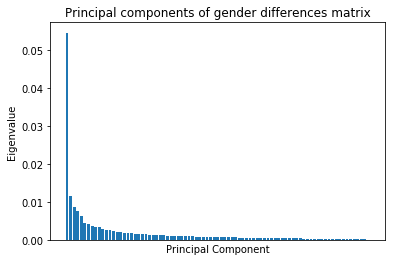

Number of pos words: 85 Number of neg words: 85


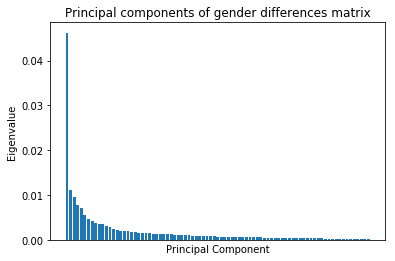

In [64]:
eig_plot('gender', pos=True,)
eig_plot('gender', pos=False)

### Second, let's look to see if these directions are unique. Perhaps they are all just capturing sentiment (good vs bad)?

In [19]:
#extract all four direction vectors:
pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('gender')
genderdirectionVec= PCA_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)
   
pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('moral')
moraldirectionVec= PCA_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('health')
healthdirectionVec= PCA_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('ses')
sesdirectionVec= PCA_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

Number of pos words: 85 Number of neg words: 85
Number of pos words: 80 Number of neg words: 80
Number of pos words: 65 Number of neg words: 65
Number of pos words: 50 Number of neg words: 50


In [20]:
print("Cosine Similarity between gender and morality is: " + str(1 - spatial.distance.cosine(genderdirectionVec, moraldirectionVec))) #similarity is 1-distance
print("Cosine Similarity between gender and health is: " + str(1 - spatial.distance.cosine(genderdirectionVec, healthdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between gender and ses is: " + str(1 - spatial.distance.cosine(genderdirectionVec, sesdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between morality and health is: " + str(1 - spatial.distance.cosine(moraldirectionVec, healthdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between morality and ses is: " + str(1 - spatial.distance.cosine(moraldirectionVec, sesdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between health and ses is: " + str(1 - spatial.distance.cosine(healthdirectionVec, sesdirectionVec))) #similarity is 1-distance

Cosine Similarity between gender and morality is: (0.0368789629154+0j)
Cosine Similarity between gender and health is: (-0.182066491801+0j)
Cosine Similarity between gender and ses is: (0.039620759502+0j)
Cosine Similarity between morality and health is: (0.241625545069+0j)
Cosine Similarity between morality and ses is: (0.0586030793759+0j)
Cosine Similarity between health and ses is: (-0.134672204777+0j)


From Word2Vec models used to develop this code, morality and health are quite similar, though not exactly the same. Gender is not similar to any others, and health, morality, and ses have some similarity. Perhaps another future route to improve these dirctions even more is to find a "sentiment" direction, and find the each the vector *rejection* of morality, health, and SES on to sentiment, to "eliminate" sentiment. 

In [ ]:
#np.savetxt("sesdirectionVec.csv", sesdirectionVec, delimiter=",") #if you want to save a direction vector you extracted!

# Part 3: Let's extract a dimension and then project training, testing, and obesity words onto that direction

In [21]:
def select_testing_set(testingset):
    if testingset=='gender':
        test_word_list= ['goddess', 'single_mother', 'girlish', 'feminine', 'young_woman', 'little_girl', 'ladylike', 'my_mother', 
           'teenage_daughter', 'mistress', 'great_grandmother', 'adopted_daughter', 'femininity', 'motherly', 'matronly', 
           'showgirl', 'housewife', 'vice_chairwoman', 'co_chairwoman', 'spokeswoman', 'governess', 'divorcee', 'spinster', 
           'maid', 'countess', 'pregnant_woman', 'landlady', 'seamstress', 'young_girl', 'waif', 'femme_fatale','comedienne',
            'boyish', 'masculine',  'lad', 'policeman', 'macho', 'gentlemanly', 'machismo',  'teenage_son', 
            'beau', 'great_grandfather', 'tough_guy', 'masculinity', 'bad_boy', 'spokesman', 'baron', 'adult_male', 'landlord', 'fireman', 'mailman', 'vice_chairman', 
           'co_chairman','young_man', 'bearded', 'mustachioed', 'con_man', 'homeless_man', 'gent', 'strongman']
        test_classes=np.repeat(1, 31).tolist() #1 is feminine
        masc2=np.repeat(0, 29).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i) 
    elif testingset=='moral':
        test_word_list= ['great', 'best', 'faith', 'chaste', 'wholesome', 'noble', 'honorable', 'immaculate', 'gracious', 
           'courteous', 'delightful', 'earnest', 'amiable', 'admirable', 'disciplined', 'patience', 'integrity',
            'restraint', 'upstanding', 'diligent', 'dutiful', 'loving', 'righteous','respectable', 'praise', 'devout', 'forthright',
            'depraved', 'repulsive', 'repugnant', 'corruption', 'vicious', 'unlawful', 'outrage',  'shameless', 'perverted',
            'filthy', 'lewd', 'subversive', 'sinister', 'murderous', 'perverse', 
           'monstrous', 'homicidal', 'indignant', 'misdemeanor', 'degenerate', 'malevolent', 'illegal','terrorist','terrorism',  
             'cheated', 'vengeful', 'culpable','vile', 'hateful', 'abuse', 'abusive', 'criminal', 'deviant']
        test_classes=np.repeat(1, 26 ).tolist() #1 is feminine
        masc2=np.repeat(0,34).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i)
    elif testingset=='health':
        test_word_list= [ 'balanced_diet', 'healthfulness', 'fiber', 'jogging', 'stopping_smoking', 'vigor', 
          'active', 'fit', 'flourishing', 'sustaining', 'hygienic', 'hearty', 'enduring', 'energized', 'wholesome', 
           'holistic', 'healed', 'fitter', 'health_conscious', 'more_nutritious', 'live_longer',  'exercising_regularly',
           'healthier_choices', 'healthy_habits', 'healthy_lifestyle', 'healthful_eating', 'immune', 
            'deadly', 'diseased',  'adverse', 'risky', 'fatal', 'filthy', 'epidemic', 'crippling', 'carcinogenic', 'carcinogen',
           'crippled', 'afflicted', 'contaminated', 'fatigued', 'detrimental', 'bedridden', 'incurable', 'hospitalized',
           'infected', 'ailing', 'debilitated', 'poisons', 'disabling', 'life_threatening', 'debilitating', 
           'chronic_illness', 'artery_clogging', 'hypertension','disease', 'stroke',
            'plague', 'fatty', 'smoking']
        test_classes=np.repeat(1, 26).tolist() #1 is feminine
        masc2=np.repeat(0, 34 ).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i) 
    elif testingset=='ses':
        test_word_list= ['rich', 'billionaire', 'banker',  'fortune', 'heiress', 'cosmopolitan', 'ornate', 'entrepreneur', 'sophisticated',
                'aristocratic', 'investor', 'highly_educated', 'better_educated',  'splendor', 
               'businessman', 'opulent', 'multimillionaire', 'philanthropist', 'estate', 'estates', 'chateau', 'fortunes', 
               'financier', 'young_professionals','tycoon', 'baron', 'grandeur', 'magnate', 
               'investment_banker', 'venture_capitalist', 'upwardly_mobile', 'highly_skilled', 'yuppies', 'genteel',
                         'homelessness', 'ruin', 'ruined', 'downtrodden', 'less_affluent',
                'housing_project', 'homeless_shelters', 'indigent', 'jobless', 'welfare',  
                'temporary_shelters','housing_projects', 'subsidized_housing', 'starving', 'beggars', 'orphanages',
                'dispossessed', 'uninsured', 'welfare_recipients', 'food_stamps', 
                'malnutrition',  'underemployed', 'disenfranchised', 'servants', 'displaced', 'poor_families'] 
        test_classes=np.repeat(1, 33).tolist()#1 is feminine
        masc2=np.repeat(0, 27).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i) 
    elif testingset=='gender_stereotypes':
        test_word_list=['petite', 'cooking', 'graceful',  'housework', 'soft', 'whisper', 'flirtatious', 'accepting', 'blonde', 'blond', 'doll', 'dolls','nurse',  'estrogen', 'lipstick','pregnant', 'nanny', 'pink', 
                 'sewing', 'modeling', 'dainty', 'gentle', 'children','pregnancy', 'nurturing', 'depressed', 'nice', 'emotional','depression', 'home', 'kitchen', 'quiet', 'submissive',
                   'soldier', 'army', 'drafted', 'military',   'beard', 'mustache', 'genius', 'engineering', 'math', 
                  'brilliant', 'strong', 'strength',  'politician', 'programmer','doctor', 'sexual', 'aggressive', 
                    'testosterone', 'tall', 'competitive', 'big', 'powerful', 'mean', 'sports', 'fighting', 'confident', 'rough', 'loud', 'worldly',
                   'experienced', 'insensitive', 'ambitious', 'dominant']
        test_classes=np.repeat(1, 33 ).tolist() #1 is feminine
        masc2=np.repeat(0,33).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i) 
    else:
        print('choose a testing set: gender, moral, health, ses, or gender_stereotypes')
        
    test_words=[]
    test_word_list_checked=[]
    for i in test_word_list:
        try:
            test_words.append(currentmodel[i])
            test_word_list_checked.append(i)
        except KeyError:
            print(str(i) +  ' was not in this Word2Vec models vocab, and has been removed as a test word')
            index_missing= test_word_list.index(i)
            del(test_classes[index_missing])
            #test_words.append(currentmodel[test_word_replacement])
            #test_word_list_checked.append(test_word_replacement)
            #get index of word, and remove this from classes, and do not append to list of vectors and word-list

    test_words= np.asarray(test_words)
    print("Number of test words: " + str(len(test_words)))
    
    return(test_word_list_checked, test_words, test_classes)

#### Do Projections

In [30]:
def do_projections(subspace, new_word_list):
    pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set(subspace)
    test_word_list,test_words, test_classes = select_testing_set(subspace)
    directionVec= PCA_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)
    
    #In a given model, we don't initially know the "direction" of a dimensions. In other words, we don't know whether a positive projection will be feminine or masculine. So, inductively find the correct labels 1/0. 
    #Consider this assumption that embedded in the code carefully when interpreting accuracy rates  
    pos_class=[] 
    for word in range(0, len(train_classes_pos)): #for word in this set of training words
        wordToProject=np.hstack(normalizeME(pos_words[word]))
        proj=project(wordToProject, directionVec)
        if proj > 0:
            pos_class.append(1) #evidence from this training word that the "positive words" are learned as positive
        elif proj < 0:
            pos_class.append(0) #evidence from this training word that the "positive words" are learned as negative
    
    #Now get predictions on the training set
    predictions_train=[]
    projections_train=[]
    combinedposnegtrain= np.concatenate([pos_words, neg_words], axis=0)
    train_classes=np.concatenate([train_classes_pos, train_classes_neg], axis=0) 
    if statistics.mode(pos_class)==1: #if the positive class is mostly 1, keep labels as is. Note that if the positive class is split exactly 50/50 this won't work, but also then accuracy is equal to flip of coin.    
        for word in range(0, len(combinedposnegtrain)):
            wordToProject=np.hstack(normalizeME(combinedposnegtrain[word]))
            proj=project(wordToProject, directionVec)
            projections_train.append(proj)
            if proj > 0:
                predictions_train.append(1)
            elif proj<0:
                predictions_train.append(0)
    elif statistics.mode(pos_class)==0: #if the positive class is mostly -1, reverse labels
        for word in range(0, len(combinedposnegtrain)):
            wordToProject=np.hstack(normalizeME(combinedposnegtrain[word]))
            proj=project(wordToProject, directionVec)
            projections_train.append(-(proj))
            if proj > 0:
                predictions_train.append(0)
            elif proj<0:
                predictions_train.append(1)
    else:
        print("No clear label")

    
    #Now get predictions on the testing set
    predictions_test=[]
    projections_test=[]
    if statistics.mode(pos_class)==1:
        for word in range(0, len(test_words)):
            wordToProject=np.hstack(normalizeME(test_words[word]))
            proj=project(wordToProject, directionVec)
            projections_test.append(proj)
            if proj > 0:
                predictions_test.append(1)
            elif proj< 0:
                predictions_test.append(0)
    elif statistics.mode(pos_class)==0:
        for word in range(0, len(test_words)):
            wordToProject=np.hstack(normalizeME(test_words[word]))
            proj=project(wordToProject, directionVec)
            projections_test.append(-(proj))
            if proj > 0:
                predictions_test.append(0)
            elif proj< 0:
                predictions_test.append(1)
    else:
        print("No clear label")

    trainacc=accuracy_score(train_classes, predictions_train)
    testacc=accuracy_score(test_classes, predictions_test)
    trainacc_N=accuracy_score(train_classes, predictions_train, normalize=False)
    testacc_N=accuracy_score(test_classes, predictions_test, normalize=False)
    #print('Percent- Training accuracy: '+  str(trainacc))
    #print('Number- Training accuracy: ' + str(trainacc_N))
    print('Percent- Training accuracy: '+  str(trainacc) + " Testing accuracy: " + str(testacc))
    print('Number- Training accuracy: ' + str(trainacc_N) + " Testing accuracy: " + str(testacc_N))
    
    predictions_new_word_list=[]
    projections_new_word_list=[]
    if new_word_list is not None:
        if statistics.mode(pos_class)==1:
            for word in range(0, len(new_word_list)):
                wordToProject=np.hstack(normalizeME(currentmodel[new_word_list[word]]))
                proj=project(wordToProject, directionVec)
                projections_new_word_list.append(proj)
                if proj > 0:
                    predictions_new_word_list.append(1)
                elif proj< 0:
                    predictions_new_word_list.append(0)
        elif statistics.mode(pos_class)==0:
            for word in range(0, len(new_word_list)):
                wordToProject=np.hstack(normalizeME(currentmodel[new_word_list[word]]))
                proj=project(wordToProject, directionVec)
                projections_new_word_list.append(-(proj))
                if proj > 0:
                    predictions_new_word_list.append(0)
                elif proj< 0:
                    predictions_new_word_list.append(1)
        else:
            print("No clear label")
    
    return(np.concatenate([pos_word_list, neg_word_list], axis=0), predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list,  projections_new_word_list)

#### do_projections wraps up a lot of the previous functions we've been using and returns projections and other data you'll want! Let's use it:

In [39]:
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list, projections_new_word_list = do_projections('gender', None)

Number of pos words: 85 Number of neg words: 85
Number of test words: 60
Percent- Training accuracy: 0.894117647059 Testing accuracy: 0.933333333333
Number- Training accuracy: 152 Testing accuracy: 56


#### Some Preliminary Visualization
*Tip: export all the data with code below to create better plots with GGPlot in R*

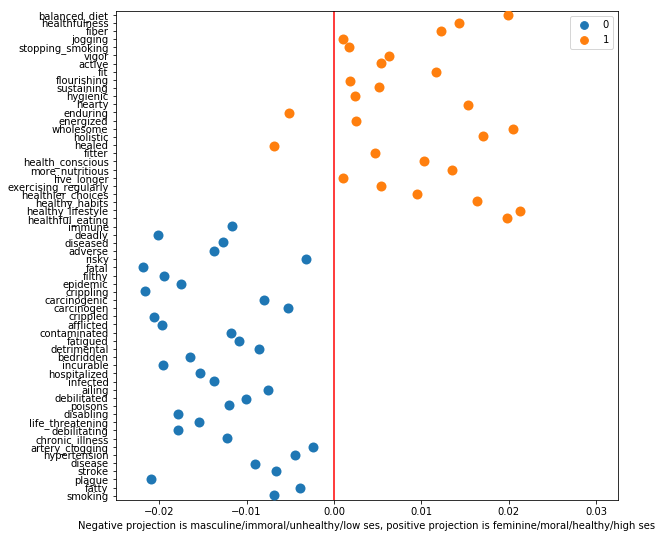

In [17]:
import seaborn as sns
from pylab import rcParams
from pylab import xlim

rcParams['figure.figsize'] = 9,9
#xlim([-.03, .03])
myplot= sns.stripplot(projections_test, test_word_list, test_classes, jitter=True, size=10)
plt.axvline(x=0, color='r', linestyle='-')
plt.xlabel('Negative projection is masculine/immoral/unhealthy/low ses, positive projection is feminine/moral/healthy/high ses')
plt.show()

#### Lets see how some stereotypicallly gendered words are classified with this method!
Try adding in other gender stereotypes here!

In [18]:
gender_stereotypes=['petite', 'cooking', 'graceful',  'housework', 'soft', 'whisper', 'flirtatious', 'accepting', 'blonde', 'blond', 'doll', 'dolls','nurse',  'estrogen', 'lipstick','pregnant', 'nanny', 'pink', 
                 'sewing', 'modeling', 'dainty', 'gentle', 'children','pregnancy', 'nurturing', 'depressed', 'nice', 'emotional','depression', 'home', 'kitchen', 'quiet', 'submissive',
                   'soldier', 'army', 'drafted', 'military',   'beard', 'mustache', 'genius', 'engineering', 'math', 
                  'brilliant', 'strong', 'strength',  'politician', 'programmer','doctor', 'sexual', 'aggressive', 
                    'testosterone', 'tall', 'competitive', 'big', 'powerful', 'mean', 'sports', 'fighting', 'confident', 'rough', 'loud', 'worldly',
                   'experienced', 'insensitive', 'ambitious', 'dominant']

train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list, projections_new_word_list  = do_projections('gender', gender_stereotypes)

Number of pos words: 85 Number of neg words: 85
Number of test words: 60
Percent- Training accuracy: 0.852941176471 Testing accuracy: 0.883333333333
Number- Training accuracy: 145 Testing accuracy: 53


#### More preliminary visualization
*Tip: export all the data with code below to create better plots with GGPlot in R*

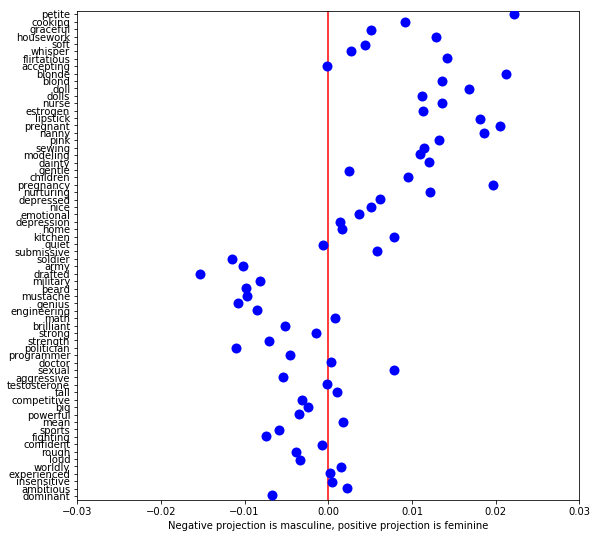

In [20]:
rcParams['figure.figsize'] = 9,9
xlim([-.03, .03])
myplot= sns.stripplot(projections_new_word_list, gender_stereotypes, color= 'blue', jitter=True, size=10)
plt.axvline(x=0, color='r', linestyle='-')
plt.xlabel('Negative projection is masculine, positive projection is feminine')
plt.show()

#### Now lets try with obese words:

In [21]:
obese_words= ['obese', 'obesity', 'diabetic', 'diabetes', 'weight', 'overweight', 'thin', 'slender', 'burly',
                'muscular', 'diet', 'dieting', 'health', 'healthy', 'unhealthy', 'fat', 'anorexic', 'anorexia', 'bulimia', 
                'beautiful', 'handsome', 'overeating', 'exercise', 'sedentary', 'bulimic', 'morbidly_obese', 'normal_weight',
                'seriously_overweight']

train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list, projections_new_word_list  = do_projections('gender', obese_words)

Number of pos words: 85 Number of neg words: 85
Number of test words: 60
Percent- Training accuracy: 0.852941176471 Testing accuracy: 0.883333333333
Number- Training accuracy: 145 Testing accuracy: 53


#### More preliminary visualization
*Tip: export all the data with code below to create better plots with GGPlot in R*

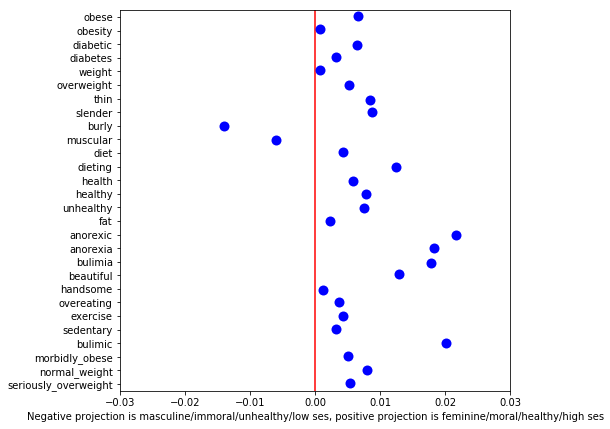

In [22]:
rcParams['figure.figsize'] = 7, 7
xlim([-.03, .03])
myplot= sns.stripplot(projections_new_word_list, obese_words, color= 'blue', jitter=True, size=10)
plt.axvline(x=0, color='r', linestyle='-')
plt.xlabel('Negative projection is masculine/immoral/unhealthy/low ses, positive projection is feminine/moral/healthy/high ses')
plt.show()

#### Write projection for training/testing/obese keywords results to a CSV

In [44]:
#written here for gender, or specify in "do_projections" below for moral, health, or ses
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list, projections_new_word_list  = do_projections('gender', obese_words)

with open(r'results5.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(['Gender_Train']*len(train_word_list))  #change the headings as needed for Gender,Moral, Health, SES
    writer.writerow(train_word_list)
    writer.writerow(train_classes)
    writer.writerow(projections_train)
    writer.writerow(predictions_train)
   
    writer.writerow(['Gender_Test']*len(test_word_list)) #change the headings as needed for Gender, Moral, Health, SES
    writer.writerow(test_word_list)
    writer.writerow(test_classes)
    writer.writerow(predictions_test)
    writer.writerow(projections_test)
    
    writer.writerow(['Gender_Obesity']*len(obese_words)) #change the headings as needed for Gender, Moral, Health, SES, and if another set of words other than the obese_words are used here
    writer.writerow(obese_words)
    writer.writerow(predictions_new_word_list)
    writer.writerow(projections_new_word_list)

Number of pos words:85 Number of neg words:85
Number of test words: 60
Percent- Training accuracy: 0.852941176471 Testing accuracy: 0.883333333333
Number- Training accuracy: 145 Testing accuracy: 53
